In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

# Load dataset

In [3]:
oil = pd.read_csv('./oil_prices.csv', parse_dates=['Date'], index_col='Date')
oil['Price'] = [float(str(i).replace(",", ".")) for i in oil['Price']]
oil = oil.loc['2005':]
oil.head()

,Price
Date,
2005-01-04,40.75
2005-01-05,41.00
2005-01-06,43.25
2005-01-07,43.28
2005-01-10,44.71


In [4]:
ingredient = pd.read_csv('./ingredient_prices.csv', parse_dates=['Date'], index_col = 'Date')
ingredient['Price'] = [float(str(i).replace(",", ".")) for i in ingredient['Price']]
ingredient.head()

,Price
Date,
2005-01-01,570.0
2005-02-01,570.0
2005-03-01,610.0
2005-04-01,600.0
2005-05-01,570.0


In [5]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3901 entries, 2005-01-04 to 2020-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   3891 non-null   float64
dtypes: float64(1)
memory usage: 61.0 KB


In [6]:
ingredient.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2005-01-01 to 2020-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   183 non-null    float64
dtypes: float64(1)
memory usage: 2.9 KB


# EDA

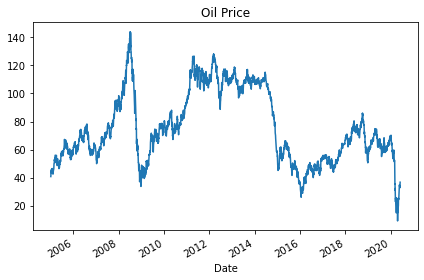

In [24]:
oil.Price.plot(title='Oil Price')
plt.tight_layout()
plt.savefig('./Plots/oil_prince.png', dpi=300)
plt.show()

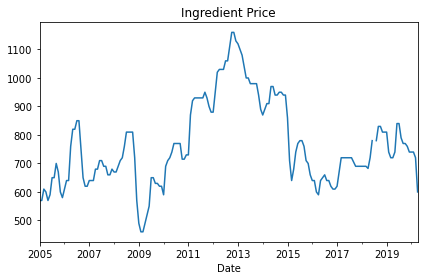

In [23]:
ingredient.Price.plot(title='Ingredient Price')
plt.tight_layout()
plt.savefig('./Plots/ingredient_price.png', dpi=300)
plt.show()

## Data Cleaning

### Oil

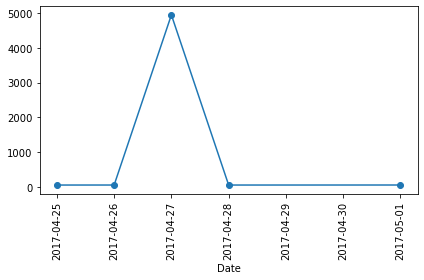

In [9]:
plt.plot(oil['2017-4-25':'2017-5-1'],marker='o')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('./Plots/oil_outlier.png', dpi=300)
plt.show()

In [10]:
oil['2017-4-25':'2017-5-1']

,Price
Date,
2017-04-25,49.37
2017-04-26,49.99
2017-04-27,4946.00
2017-04-28,49.46
2017-05-01,50.41


In [13]:
oil.loc['2017-4-27']['Price'] = 49.46

### Ingredients

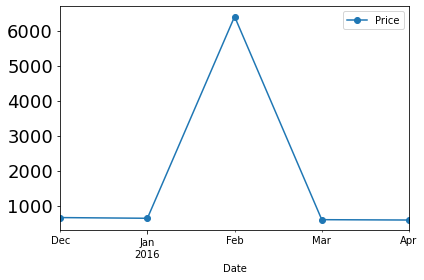

In [16]:
ingredient['2015-12':'2016-4'].plot(marker='o')
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('./Plots/ingredient_outlier1.png', dpi = 300, transparent=True)
plt.show()

In [17]:
ingredient['2015-12':'2016-4']

,Price
Date,
2015-12-01,660.0
2016-01-01,640.0
2016-02-01,6400.0
2016-03-01,600.0
2016-04-01,590.0


In [19]:
ingredient.loc['2016-2-1']['Price'] = 640.0

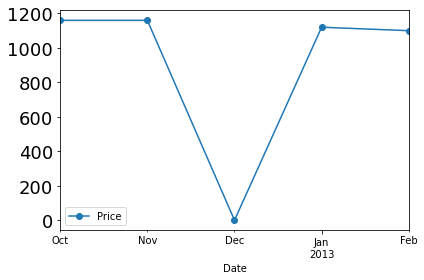

In [20]:
ingredient['2012-10':'2013-2'].plot(marker='o')
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig('./Plots/ingredient_outlier2.png', dpi = 300, transparent=True)
plt.show()

In [21]:
ingredient['2012-10':'2013-2']

,Price
Date,
2012-10-01,1160.00
2012-11-01,1160.00
2012-12-01,1.13
2013-01-01,1120.00
2013-02-01,1100.00


In [22]:
ingredient.loc['2012-12-1']['Price'] = 1130.00